<a href="https://colab.research.google.com/github/JuanZapa7a/semiotics/blob/main/QAT_MNIST_NOISY_CMOS_NL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantization Aware Training (QAT) using Larq for a noisy CMOS binarized quantization with the CIFAR10 dataset

## 1. Installation of Larq and necessary dependencies

In [1]:
!pip -q install tensorflow==2.10.0
!pip -q install larq==0.13.1

import tensorflow as tf
import larq as lq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
google-cloud-aipla

## 2. Data preparation (MNIST)

Download and prepare the MNIST dataset.

By default, each MNIST image has a shape of (28, 28), which is 2D.
However, neural networks (especially convolutional networks) typically expect 3D inputs: (height, width, channels).
Adding a channel dimension (with value 1 for grayscale) changes each image shape from (28, 28) to (28, 28, 1), which is required for most neural network layers to interpret the images correctly.
The overall shapes for the dataset become (60000, 28, 28, 1) for training and (10000, 28, 28, 1) for testing.

The MNIST dataset’s pixel values originally range from 0 to 255.
Dividing by 127.5 and then subtracting 1 maps the values to a -1 to 1 range, which can help certain models converge more quickly and maintain numerical stability. (Centering pixel values around zero often benefits neural networks as it reduces bias and helps gradient-based methods perform better.)

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)) # (60000, 28, 28) (60000,)
test_images = test_images.reshape((10000, 28, 28, 1)) # (10000, 28, 28) (10000,)

# For binarized models, it is standard to normalize images to a range between -1 and 1.
train_images, test_images = train_images / 127.5 - 1,test_images / 127.5 - 1

print(train_images.shape, train_labels.shape)  # Debe ser (60000, 28, 28, 1), (60000,)
print(test_images.shape, test_labels.shape)    # Debe ser (10000, 28, 28, 1), (10000,)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


## 3. AÑADIENDO RUIDO A LOS PESOS Y A LAS ACTIVACIONES

Para modificar el código y permitir que el ruido se inyecte tanto en los pesos como en las activaciones, podemos expandir la lógica de la clase `NoisyLayer`. Además, sí, las imágenes de entrada podrían venir con ruido (simulando ruido real del sensor o del ambiente), lo que podría mejorarse añadiendo ruido a las activaciones de cada capa.

### **Código modificado para añadir ruido  a los pesos y activaciones:**

1. **Inyectar ruido en las activaciones**:
    - Modifica la función `call` de `NoisyLayer` para agregar ruido a las activaciones después de aplicar la lógica de la capa base.
2. **Simular ruido en la entrada (opcional)**:
    - Añade una capa adicional de ruido a las imágenes de entrada con `tf.keras.layers.GaussianNoise`.

### **Explicación de los cambios**

#### 1. **Ruido en activaciones**

- Después de aplicar la lógica de la capa base (`self.wrapped_layer(inputs)`), se genera ruido para las activaciones con:
    
    ```python
    activation_noise = tf.random.normal(
        shape=tf.shape(outputs),
        mean=self.noise_mean,
        stddev=self.noise_stddev_activations
    )
    outputs_noisy = outputs + activation_noise
    ```
    
- Esto inyecta ruido gaussiano en las salidas de cada capa.

#### 2. **Simulación de imágenes de entrada con ruido**

- La capa `tf.keras.layers.GaussianNoise` añade ruido gaussiano directamente a las imágenes de entrada:
    
    ```python
    model.add(tf.keras.layers.GaussianNoise(0.05, input_shape=(28, 28, 1)))
    ```
    
- Esto simula el ruido que podría provenir de sensores o entornos del mundo real.

#### 3. **Parámetros separados para ruido en pesos y activaciones**

- `noise_stddev_weights`: Desviación estándar para el ruido en los pesos.
- `noise_stddev_activations`: Desviación estándar para el ruido en las activaciones.

---

### **Escenarios del ruido en imágenes**

La simulación de ruido en las imágenes puede ser útil para:

1. **Robustez a entradas ruidosas**:
    - Por ejemplo, cámaras con baja iluminación, sensores defectuosos, o datos transmitidos con ruido.
2. **Regularización adicional**:
    - Similar a `Dropout`, añade variabilidad a las entradas, evitando que el modelo dependa de patrones específicos.

---

### **Resultados esperados**

Con este enfoque:

- El modelo será más robusto a perturbaciones tanto en las entradas como en las representaciones internas (activaciones y pesos).
- Se puede usar para estudiar cómo el ruido afecta al rendimiento en diferentes partes del pipeline de entrenamiento.

In [3]:
import larq as lq
import tensorflow as tf

# Define a custom layer to add noise to weights and activations
class NoisyLayer(tf.keras.layers.Layer):
    def __init__(self, wrapped_layer, noise_mean=0.0, noise_stddev_weights=0.01, noise_stddev_activations=0.01, **kwargs):
        super().__init__(**kwargs)
        self.wrapped_layer = wrapped_layer                 # Original layer to wrap
        self.noise_mean = noise_mean                       # Mean of the noise
        self.noise_stddev_weights = noise_stddev_weights   # Stddev of noise for weights
        self.noise_stddev_activations = noise_stddev_activations  # Stddev of noise for activations

    def build(self, input_shape):
        # Build the wrapped layer
        self.wrapped_layer.build(input_shape)
        super().build(input_shape)

    def call(self, inputs):
        # Add noise to weights
        for weight in self.wrapped_layer.trainable_weights:
            noise = tf.random.normal(
                shape=tf.shape(weight),
                mean=self.noise_mean,
                stddev=self.noise_stddev_weights
            )
            noisy_weight = weight + noise  # Add noise to weights
            weight.assign(noisy_weight)   # Assign the noisy weights temporarily

        # Forward pass through the wrapped layer
        outputs = self.wrapped_layer(inputs)

        # Add noise to activations
        activation_noise = tf.random.normal(
            shape=tf.shape(outputs),
            mean=self.noise_mean,
            stddev=self.noise_stddev_activations
        )
        outputs_noisy = outputs + activation_noise

        return outputs_noisy

# Define default quantization options for quantized layers
kwargs = dict(
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
)

# Initialize a Sequential model
model_wa = tf.keras.models.Sequential()

# Add noise to input images (simulate noisy input images)
model_wa.add(tf.keras.layers.GaussianNoise(0.05, input_shape=(28, 28, 1)))

# First convolutional layer with noise on weights and activations
model_wa.add(NoisyLayer(
    lq.layers.QuantConv2D(
        32, (3, 3),
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        use_bias=False
    ),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01
))
model_wa.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_wa.add(tf.keras.layers.BatchNormalization(scale=False))

# Second convolutional layer with noise on weights and activations
model_wa.add(NoisyLayer(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01
))
model_wa.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_wa.add(tf.keras.layers.BatchNormalization(scale=False))

# Third convolutional layer with noise on weights and activations
model_wa.add(NoisyLayer(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01
))
model_wa.add(tf.keras.layers.BatchNormalization(scale=False))
model_wa.add(tf.keras.layers.Flatten())

# Dense layer with noise on weights and activations
model_wa.add(NoisyLayer(
    lq.layers.QuantDense(64, use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01
))
model_wa.add(tf.keras.layers.BatchNormalization(scale=False))

# Output layer with noise on weights and activations
model_wa.add(NoisyLayer(
    lq.layers.QuantDense(10, use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01
))
model_wa.add(tf.keras.layers.BatchNormalization(scale=False))
model_wa.add(tf.keras.layers.Activation("softmax"))

# Especificar la forma de entrada (28, 28, 1) para imágenes MNIST
model_wa.build((None, 28, 28, 1))

# Summarize the model with Larq
lq.models.summary(model_wa)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7cc2e27606d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7cc2e27606d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
+sequential stats-----------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory |
|                              (bit)                        x 1       x 1    (kB) |
+---------------------------------------------------------------------------------+
| gaussian_noise                   -   (-1, 28, 28, 1)        0         0       0 |
| noisy_layer                      -  (-1, 26, 26, 32)      288         0    0.04 |
| max_pooling2d                    -  (-1, 13, 13, 32)        0         0       0 |
| batch_normalization              -  (-1, 13, 13, 32)        0        64    0.25 |
| noisy_layer_1          

## Explicación de la salida

Esta salida proporciona un resumen detallado de las características del modelo secuencial con cuantización y las estadísticas asociadas. Aquí está una explicación paso a paso de cada sección:

### **1. Tabla de capas con estadísticas (`+sequential stats+`)**
#### **Columnas principales:**
- **Layer**: Nombre de la capa en el modelo.
- **Input prec. (bit)**: Precisión de los datos de entrada (no especificada aquí porque varía).
- **Outputs**: Dimensión de la salida de la capa.
- **# 1-bit**: Número de pesos binarios (1-bit) en la capa.
- **# 32-bit**: Número de parámetros de 32 bits (normalmente de Batch Normalization).
- **Memory (kB)**: Memoria requerida para almacenar los parámetros de la capa.

#### **Detalles por capa:**
1. **`gaussian_noise`**:
   - Agrega ruido gaussiano al input. No tiene parámetros ni memoria asignada (solo afecta durante el entrenamiento).

2. **`noisy_layer`**:
   - La primera capa convolucional cuantizada con 32 filtros de 3x3:
     - **288 pesos binarios (1-bit)**, calculados como: $ 3 \times 3 \times 1 \times 32 = 288 $.
     - **0 parámetros de 32 bits** porque la capa no usa sesgo.
     - Memoria: **0.04 kB** (288 bits = 36 bytes = 0.04 kB).

3. **`max_pooling2d`**:
   - Reduce la dimensión espacial de la salida sin usar parámetros.

4. **`batch_normalization`**:
   - Normaliza la salida del pooling:
     - **64 parámetros de 32 bits** (2 por filtro: media y desviación estándar).
     - Memoria: **0.25 kB**.

5. **`noisy_layer_1`**:
   - Segunda capa convolucional con 64 filtros de 3x3:
     - **18432 pesos binarios (1-bit)**, calculados como: $ 3 \times 3 \times 32 \times 64 = 18432 $.
     - Memoria: **2.25 kB**.

6. **`batch_normalization_1`**:
   - Igual que el anterior, pero ahora con **128 parámetros de 32 bits** porque hay 64 filtros.

7. **`noisy_layer_2`**:
   - Tercera capa convolucional:
     - **36864 pesos binarios (1-bit)**, calculados como: $ 3 \times 3 \times 64 \times 64 = 36864 $.
     - Memoria: **4.50 kB**.

8. **`flatten`**:
   - Aplana la salida para conectarla a capas densas. No tiene parámetros.

9. **`noisy_layer_3`**:
   - Capa densa con 64 unidades:
     - **36864 pesos binarios (1-bit)**, calculados como: $ 576 \times 64 = 36864 $.
     - Memoria: **4.50 kB**.

10. **`noisy_layer_4`**:
    - Capa de salida densa con 10 unidades:
      - **640 pesos binarios (1-bit)**, calculados como: $ 64 \times 10 = 640 $.
      - Memoria: **0.08 kB**.

11. **`activation`**:
    - Usa una función `softmax`. No tiene parámetros.


### **2. Resumen general (`+sequential summary+`)**
#### **Estadísticas importantes:**
- **Total params**: Número total de parámetros:
  - **93.6 k**: Representa 93088 pesos binarios (1-bit) y 468 parámetros de 32 bits.

- **Trainable params**: Parámetros ajustables durante el entrenamiento:
  - **93.1 k**, que incluye los pesos binarios (1-bit) y parámetros de Batch Normalization.

- **Non-trainable params**: Parámetros que no se ajustan (e.g., estadísticas acumuladas en Batch Normalization):
  - **468**.

- **Model size**:
  - **13.19 KiB**: Tamaño total del modelo en memoria comprimida (pesos binarios).
  - **Model size (8-bit FP weights)**: Si se almacenaran en precisión de 8 bits, ocuparían **11.82 KiB**.
  - **Float-32 Equivalent**: Si todos los pesos fueran flotantes de 32 bits, el modelo ocuparía **365.45 KiB**.

- **Compression Ratio of Memory**:
  - **0.04**: Indica que el modelo es 25 veces más pequeño (4%) en comparación con su equivalente en punto flotante de 32 bits.

- **Number of MACs**:
  - **0**: Esto puede deberse a que el modelo usa operaciones de conteo de bits (binarias) en lugar de acumulaciones/multiplicaciones tradicionales (MAC).

### **Conclusión**
La salida refleja que este modelo es **altamente eficiente en términos de memoria**, gracias al uso de **cuantización binaria** para los pesos. Aunque esto reduce la precisión de los cálculos, el modelo sigue siendo compacto y adecuado para dispositivos con recursos limitados, como hardware IoT o ASICs personalizados.

La salida refleja que este modelo es **altamente eficiente en términos de memoria**, gracias al uso de **cuantización binaria** para los pesos. Aunque esto reduce la precisión de los cálculos, el modelo sigue siendo compacto y adecuado para dispositivos con recursos limitados, como hardware IoT o ASICs personalizados.

El número de operaciones MAC (multiplicación-acumulación) aparece como **0** porque el modelo usa **cuantización binaria** para los pesos y, posiblemente, para las activaciones. Esto elimina las operaciones tradicionales de multiplicación y acumulación en favor de operaciones mucho más simples, como **suma de conteos de bits** o **XOR**. Veamos por qué y cuál es el impacto de esto:


### REFLEXIONES

#### **1. ¿Por qué el número de MACs es 0?**
En modelos binarizados:
- Los pesos son representados en **1-bit**.
- Las multiplicaciones de precisión completa entre activaciones y pesos se reemplazan por:
  - Operaciones binarias, como XOR, para simular multiplicaciones.
  - Sumas de bits resultantes para reemplazar acumulaciones.

Dado que estas operaciones no son multiplicaciones reales en punto flotante o fijo (y Larq optimiza el modelo para hardware binario), no se cuentan como MACs tradicionales.

#### **2. ¿Tiene sentido modelar las variaciones del proceso CMOS aquí?**
Sí, sigue teniendo sentido añadir las **variaciones del proceso CMOS**, incluso si el modelo no realiza operaciones MAC tradicionales. Esto se debe a que las variaciones del proceso CMOS **pueden influir en el comportamiento de las operaciones binarias y la estabilidad general del hardware**. Aquí hay algunas razones:
1. **Errores en las operaciones XOR/SUMA:**
   - Las variaciones de umbral de voltaje (Vt) pueden afectar la precisión de las operaciones XOR o sumas binarias, introduciendo errores aleatorios.

2. **Ruido en activaciones y pesos binarizados:**
   - Aunque las multiplicaciones completas se eliminan, las activaciones binarizadas y los pesos pueden estar sujetos a variaciones inducidas por CMOS. Esto podría desbalancear los resultados del conteo de bits.

3. **Hardware realista:**
   - Cuando el modelo se implementa en hardware como ASICs o FPGAs, estas variaciones afectan los cálculos a nivel físico, incluso si no hay operaciones MAC tradicionales.

#### **3. Cómo justificar la inclusión de variaciones CMOS**
Añadir variaciones del proceso CMOS puede ser útil para:
- **Simular hardware realista:** Asegurarte de que el modelo funcione bien en hardware con restricciones prácticas y variaciones físicas.
- **Aumentar la robustez:** Introducir ruido durante el entrenamiento puede hacer que el modelo sea más tolerante a los errores inducidos por hardware.
- **Analizar degradación del rendimiento:** Permitir estudiar cómo las variaciones afectan la precisión general del modelo.


### **Conclusión**
Aunque las operaciones MAC no aparecen en modelos binarizados, las variaciones del proceso CMOS afectan otros aspectos del hardware, como las operaciones XOR y el conteo de bits. Por tanto, **sí tiene sentido incluir estas variaciones** para hacer el modelo más robusto y representativo del comportamiento en hardware real. Esto es particularmente relevante si planeas implementarlo en sistemas integrados que usan tecnología CMOS.

In [4]:
# Compile the model with an optimizer and loss function
model_wa.compile(
    optimizer='adam',                      # Adam optimizer is often effective for training binarized networks
    loss="sparse_categorical_crossentropy",# Cross-entropy loss for classification
    metrics=["accuracy"]                   # Accuracy as the evaluation metric
)

# Train the model where QAT takes place as the model learns to optimize quantized weights and activations.
history_wa = model_wa.fit(
    train_images, train_labels,
    epochs=6,                           # Number of training epochs
    batch_size=64,                      # Batch size for training
    validation_data=(test_images, test_labels), # Evaluate on test set after each epoch
    shuffle=False                        # Shuffle the training data for each epoch
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_wa.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/6
938/938 [==============================] - 122s 128ms/step - loss: 1.1060 - accuracy: 0.7395 - val_loss: 1.4455 - val_accuracy: 0.5961
Epoch 2/6
938/938 [==============================] - 103s 110ms/step - loss: 0.8331 - accuracy: 0.8569 - val_loss: 0.9018 - val_accuracy: 0.8518
Epoch 3/6
938/938 [==============================] - 101s 108ms/step - loss: 0.7088 - accuracy: 0.8993 - val_loss: 0.8181 - val_accuracy: 0.8880
Epoch 4/6
938/938 [==============================] - 101s 108ms/step - loss: 0.6448 - accuracy: 0.9184 - val_loss: 0.7459 - val_accuracy: 0.9127
Epoch 5/6
938/938 [==============================] - 100s 107ms/step - loss: 0.6109 - accuracy: 0.9284 - val_loss: 0.7242 - val_accuracy: 0.9167
Epoch 6/6
313/313 [==============================] - 10s 31ms/step - loss: 0.8602 - accuracy: 0.8829
Test Accuracy: 88.29%
Test Loss: 0.8602


## 4. AÑADIENDO VARIACIONES DE PROCESO CMOS

Las variaciones de proceso pueden cambiar los parámetros de los transistores, afectando el comportamiento de las operaciones aritméticas. Esto puede modelarse como una desviación en los pesos del modelo.

### **Análisis del Código Actual**

hemos definido un modelo de red neuronal convolucional en **TensorFlow** con capas cuantizadas usando **Larq**. Además, hemos implementado una capa personalizada (`NoisyLayer`) que introduce ruido gaussiano en los pesos y activaciones de otras capas para simular imprecisiones o ruido en el hardware en un modelo CNN llamado `model_wa` (**noise in weights and activations**).

#### **Características**
1. **Capa personalizada (`NoisyLayer`)**:
   - **Pesos**: Introduce ruido gaussiano en los pesos de la capa antes de la operación `call`.
   - **Activaciones**: Añade ruido gaussiano a las salidas de la capa.

2. **Modelo secuencial (`model_wa`)**:
   - Se utiliza ruido en los datos de entrada/imagen (`GaussianNoise`).
   - Cada capa convolucional y densa está envuelta (wrapped) con `NoisyLayer` para simular hardware ruidoso.
   - Usamos Larq (`lq`) para implementar las capas cuantizadas para QAT.

3. **Finalidad del diseño**: Simular entornos con hardware real. El modelo es lo suficiente robusto frente al ruido inducido.


### **Introducciçon de Variaciones del Proceso CMOS**

El comportamiento de un circuito CMOS puede ser afectado por **variaciones de proceso**, que incluyen:
- **Threshold Voltage Variation (Vt)**: Cambios en el umbral de los transistores afectan operaciones lógicas y de cuantización.
- **Capacitive Coupling Noise**: Introduce inexactitudes adicionales.
- **Temperature-induced Drift**: Cambios estocásticos en la precisión debido a temperatura.

Para modelar estas variaciones, podemos extender el comportamiento del `NoisyLayer` para incluir:
1. **Imprecisiones en operaciones aritméticas específicas** (e.g., multiplicación, suma).
2. **Sesgo adicional en el ruido de pesos y activaciones basado en drift térmico o variación de Vt**.


### **Explicación de Modificaciones**
1. **Variación de Voltaje de Umbral (Vt)**:
   - Añadimos un término multiplicativo `1 + vt_variation` en los pesos para modelar el efecto de variaciones estocásticas del proceso CMOS.

2. **Ruido por Acoplamiento Capacitivo**:
   - Introducimos un ruido gaussiano adicional (`capacitive_noise_stddev`) en las activaciones para reflejar la interferencia de acoplamiento.

3. **Nueva Clase (`CMOSNoisyLayer`)**:
   - Esta capa personalizada es una extensión de `NoisyLayer` que incluye las variaciones mencionadas.

---

Este modelo pretende ser `más realista` para simulaciones en hardware CMOS, ya que incorpora características específicas del proceso de fabricación y las operaciones aritméticas.


In [5]:
import larq as lq
import tensorflow as tf

# Define a custom layer to add CMOS process variation effects
class CMOSNoisyLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        wrapped_layer,
        noise_mean=0.0,
        noise_stddev_weights=0.01,
        noise_stddev_activations=0.01,
        vt_variation_factor=0.001,
        capacitive_noise_stddev=0.005,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.wrapped_layer = wrapped_layer                 # Original layer to wrap
        self.noise_mean = noise_mean                       # Mean of the noise
        self.noise_stddev_weights = noise_stddev_weights   # Stddev of noise for weights
        self.noise_stddev_activations = noise_stddev_activations  # Stddev of noise for activations
        self.vt_variation_factor = vt_variation_factor     # Threshold voltage variation factor
        self.capacitive_noise_stddev = capacitive_noise_stddev  # Capacitive coupling noise

    def build(self, input_shape):
        self.wrapped_layer.build(input_shape)
        super().build(input_shape)

    def call(self, inputs):
        # Add noise to weights (including CMOS process variations)
        for weight in self.wrapped_layer.trainable_weights:
            noise = tf.random.normal(
                shape=tf.shape(weight),
                mean=self.noise_mean,
                stddev=self.noise_stddev_weights
            )
            vt_variation = tf.random.uniform(
                shape=tf.shape(weight),
                minval=-self.vt_variation_factor,
                maxval=self.vt_variation_factor
            )
            noisy_weight = weight * (1 + vt_variation) + noise  # Combine variations
            weight.assign(noisy_weight)  # Assign noisy weights temporarily

        # Forward pass through the wrapped layer
        outputs = self.wrapped_layer(inputs)

        # Add noise to activations
        activation_noise = tf.random.normal(
            shape=tf.shape(outputs),
            mean=self.noise_mean,
            stddev=self.noise_stddev_activations
        )
        capacitive_noise = tf.random.normal(
            shape=tf.shape(outputs),
            mean=0.0,
            stddev=self.capacitive_noise_stddev
        )
        outputs_noisy = outputs + activation_noise + capacitive_noise  # Add combined noise

        return outputs_noisy


# Define default quantization options for quantized layers
kwargs = dict(
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
)

# Initialize a Sequential model
model_wa_cmos = tf.keras.models.Sequential()

# Add noise to input images (simulate noisy input images)
model_wa_cmos.add(tf.keras.layers.GaussianNoise(0.05, input_shape=(28, 28, 1)))

# First convolutional layer with CMOS process noise
model_wa_cmos.add(CMOSNoisyLayer(
    lq.layers.QuantConv2D(
        32, (3, 3),
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        use_bias=False
    ),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005
))
model_wa_cmos.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_wa_cmos.add(tf.keras.layers.BatchNormalization(scale=False))

# Second convolutional layer
model_wa_cmos.add(CMOSNoisyLayer(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005
))
model_wa_cmos.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_wa_cmos.add(tf.keras.layers.BatchNormalization(scale=False))

# Third convolutional layer
model_wa_cmos.add(CMOSNoisyLayer(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005
))
model_wa_cmos.add(tf.keras.layers.BatchNormalization(scale=False))
model_wa_cmos.add(tf.keras.layers.Flatten())

# Dense layer
model_wa_cmos.add(CMOSNoisyLayer(
    lq.layers.QuantDense(64, use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005
))
model_wa_cmos.add(tf.keras.layers.BatchNormalization(scale=False))

# Output layer
model_wa_cmos.add(CMOSNoisyLayer(
    lq.layers.QuantDense(10, use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005
))
model_wa_cmos.add(tf.keras.layers.BatchNormalization(scale=False))
model_wa_cmos.add(tf.keras.layers.Activation("softmax"))

# Especificar la forma de entrada (28, 28, 1) para imágenes MNIST
model_wa_cmos.build((None, 28, 28, 1))

# Summarize the model with Larq
lq.models.summary(model_wa_cmos)

+sequential_1 stats---------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory |
|                              (bit)                        x 1       x 1    (kB) |
+---------------------------------------------------------------------------------+
| gaussian_noise_1                 -   (-1, 28, 28, 1)        0         0       0 |
| cmos_noisy_layer                 -  (-1, 26, 26, 32)      288         0    0.04 |
| max_pooling2d_2                  -  (-1, 13, 13, 32)        0         0       0 |
| batch_normalization_5            -  (-1, 13, 13, 32)        0        64    0.25 |
| cmos_noisy_layer_1               -  (-1, 11, 11, 64)    18432         0    2.25 |
| max_pooling2d_3                  -    (-1, 5, 5, 64)        0         0       0 |
| batch_normalization_6            -    (-1, 5, 5, 64)        0       128    0.50 |
| cmos_noisy_layer_2               -    (-1, 3, 3, 64)    36864         0   

In [6]:
# Compile the model with an optimizer and loss function
model_wa_cmos.compile(
    optimizer='adam',                      # Adam optimizer is often effective for training binarized networks
    loss="sparse_categorical_crossentropy",# Cross-entropy loss for classification
    metrics=["accuracy"]                   # Accuracy as the evaluation metric
)

# Train the model where QAT takes place as the model learns to optimize quantized weights and activations.
history_wa_cmos = model_wa_cmos.fit(
    train_images, train_labels,
    epochs=6,                           # Number of training epochs
    batch_size=64,                      # Batch size for training
    validation_data=(test_images, test_labels), # Evaluate on test set after each epoch
    shuffle=False                        # Shuffle the training data for each epoch
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_wa_cmos.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/6
938/938 [==============================] - 156s 164ms/step - loss: 1.1052 - accuracy: 0.7365 - val_loss: 1.2153 - val_accuracy: 0.7121
Epoch 2/6
938/938 [==============================] - 136s 145ms/step - loss: 0.8218 - accuracy: 0.8586 - val_loss: 0.9078 - val_accuracy: 0.8550
Epoch 3/6
938/938 [==============================] - 135s 144ms/step - loss: 0.7195 - accuracy: 0.8947 - val_loss: 0.8570 - val_accuracy: 0.8793
Epoch 4/6
938/938 [==============================] - 137s 146ms/step - loss: 0.6504 - accuracy: 0.9168 - val_loss: 0.7191 - val_accuracy: 0.9131
Epoch 5/6
938/938 [==============================] - 136s 145ms/step - loss: 0.6087 - accuracy: 0.9305 - val_loss: 0.6595 - val_accuracy: 0.9332
Epoch 6/6
313/313 [==============================] - 15s 47ms/step - loss: 0.7631 - accuracy: 0.9225
Test Accuracy: 92.25%
Test Loss: 0.7631


## 5. AÑADIENDO NO LINEALIDADES

Para implementar el modelo `model_wa_cmos_nl`, donde se añaden no linealidades de saturación para simular hardware real, puedes extender la funcionalidad de la capa `CMOSNoisyLayer` añadiendo una operación de saturación después de aplicar las demás variaciones y ruidos:


### Cambios clave:
1. **Saturación (`tf.clip_by_value`)**: Se añade una operación de saturación a las salidas de la capa para simular los límites de rango en hardware.
2. **Configuración de saturación**: Puedes ajustar los parámetros `saturation_min` y `saturation_max` para establecer los límites del rango permitido.

### Resultado:
El modelo `model_wa_cmos_nl` ahora incluye ruidos relacionados con procesos CMOS, ruido capacitivo y no linealidades de saturación, simulando mejor las características del hardware real.

In [7]:
import larq as lq
import tensorflow as tf

# Define a custom layer to add CMOS process variation effects and non-linearities
class CMOSNoisyLayerWithSaturation(tf.keras.layers.Layer):
    def __init__(
        self,
        wrapped_layer,
        noise_mean=0.0,
        noise_stddev_weights=0.01,
        noise_stddev_activations=0.01,
        vt_variation_factor=0.001,
        capacitive_noise_stddev=0.005,
        saturation_min=-1.0,  # Saturation minimum value
        saturation_max=1.0,  # Saturation maximum value
        **kwargs
    ):
        super().__init__(**kwargs)
        self.wrapped_layer = wrapped_layer
        self.noise_mean = noise_mean
        self.noise_stddev_weights = noise_stddev_weights
        self.noise_stddev_activations = noise_stddev_activations
        self.vt_variation_factor = vt_variation_factor
        self.capacitive_noise_stddev = capacitive_noise_stddev
        self.saturation_min = saturation_min
        self.saturation_max = saturation_max

    def build(self, input_shape):
        self.wrapped_layer.build(input_shape)
        super().build(input_shape)

    def call(self, inputs):
        # Add noise to weights (including CMOS process variations)
        for weight in self.wrapped_layer.trainable_weights:
            noise = tf.random.normal(
                shape=tf.shape(weight),
                mean=self.noise_mean,
                stddev=self.noise_stddev_weights
            )
            vt_variation = tf.random.uniform(
                shape=tf.shape(weight),
                minval=-self.vt_variation_factor,
                maxval=self.vt_variation_factor
            )
            noisy_weight = weight * (1 + vt_variation) + noise  # Combine variations
            weight.assign(noisy_weight)  # Assign noisy weights temporarily

        # Forward pass through the wrapped layer
        outputs = self.wrapped_layer(inputs)

        # Add noise to activations
        activation_noise = tf.random.normal(
            shape=tf.shape(outputs),
            mean=self.noise_mean,
            stddev=self.noise_stddev_activations
        )
        capacitive_noise = tf.random.normal(
            shape=tf.shape(outputs),
            mean=0.0,
            stddev=self.capacitive_noise_stddev
        )
        outputs_noisy = outputs + activation_noise + capacitive_noise  # Add combined noise

        # Apply saturation to simulate hardware non-linearities
        outputs_saturated = tf.clip_by_value(
            outputs_noisy,
            clip_value_min=self.saturation_min,
            clip_value_max=self.saturation_max
        )

        return outputs_saturated


# Define default quantization options for quantized layers
kwargs = dict(
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
)

# Initialize a Sequential model
model_wa_cmos_nl = tf.keras.models.Sequential()

# Add noise to input images (simulate noisy input images)
model_wa_cmos_nl.add(tf.keras.layers.GaussianNoise(0.05, input_shape=(28, 28, 1)))

# First convolutional layer with CMOS process noise and non-linearities
model_wa_cmos_nl.add(CMOSNoisyLayerWithSaturation(
    lq.layers.QuantConv2D(
        32, (3, 3),
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        use_bias=False
    ),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005,
    saturation_min=-1.0,
    saturation_max=1.0
))
model_wa_cmos_nl.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_wa_cmos_nl.add(tf.keras.layers.BatchNormalization(scale=False))

# Second convolutional layer
model_wa_cmos_nl.add(CMOSNoisyLayerWithSaturation(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005,
    saturation_min=-1.0,
    saturation_max=1.0
))
model_wa_cmos_nl.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_wa_cmos_nl.add(tf.keras.layers.BatchNormalization(scale=False))

# Third convolutional layer
model_wa_cmos_nl.add(CMOSNoisyLayerWithSaturation(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005,
    saturation_min=-1.0,
    saturation_max=1.0
))
model_wa_cmos_nl.add(tf.keras.layers.BatchNormalization(scale=False))
model_wa_cmos_nl.add(tf.keras.layers.Flatten())

# Dense layer
model_wa_cmos_nl.add(CMOSNoisyLayerWithSaturation(
    lq.layers.QuantDense(64, use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005,
    saturation_min=-1.0,
    saturation_max=1.0
))
model_wa_cmos_nl.add(tf.keras.layers.BatchNormalization(scale=False))

# Output layer
model_wa_cmos_nl.add(CMOSNoisyLayerWithSaturation(
    lq.layers.QuantDense(10, use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005,
    saturation_min=-1.0,
    saturation_max=1.0
))
model_wa_cmos_nl.add(tf.keras.layers.BatchNormalization(scale=False))
model_wa_cmos_nl.add(tf.keras.layers.Activation("softmax"))

# Especificar la forma de entrada (28, 28, 1) para imágenes MNIST
model_wa_cmos_nl.build((None, 28, 28, 1))

# Summarize the model with Larq
lq.models.summary(model_wa_cmos_nl)


+sequential_2 stats----------------------------------------------------------------------------+
| Layer                               Input prec.           Outputs  # 1-bit  # 32-bit  Memory |
|                                           (bit)                        x 1       x 1    (kB) |
+----------------------------------------------------------------------------------------------+
| gaussian_noise_2                              -   (-1, 28, 28, 1)        0         0       0 |
| cmos_noisy_layer_with_saturation              -  (-1, 26, 26, 32)      288         0    0.04 |
| max_pooling2d_4                               -  (-1, 13, 13, 32)        0         0       0 |
| batch_normalization_10                        -  (-1, 13, 13, 32)        0        64    0.25 |
| cmos_noisy_layer_with_saturation_1            -  (-1, 11, 11, 64)    18432         0    2.25 |
| max_pooling2d_5                               -    (-1, 5, 5, 64)        0         0       0 |
| batch_normalization_11      

In [16]:
# Otra posibildad

import larq as lq
import tensorflow as tf

# Define a custom layer to add CMOS process variation effects with smooth non-linearities
class CMOSNoisyLayerNL(tf.keras.layers.Layer):
    def __init__(
        self,
        wrapped_layer,
        noise_mean=0.0,
        noise_stddev_weights=0.01,
        noise_stddev_activations=0.01,
        vt_variation_factor=0.001,
        capacitive_noise_stddev=0.005,
        activation_scale=1.0,  # New: Scale factor for tanh
        **kwargs
    ):
        super().__init__(**kwargs)
        self.wrapped_layer = wrapped_layer
        self.noise_mean = noise_mean
        self.noise_stddev_weights = noise_stddev_weights
        self.noise_stddev_activations = noise_stddev_activations
        self.vt_variation_factor = vt_variation_factor
        self.capacitive_noise_stddev = capacitive_noise_stddev
        self.activation_scale = activation_scale  # Scale factor for smoother non-linearity

    def build(self, input_shape):
        self.wrapped_layer.build(input_shape)
        super().build(input_shape)

    def call(self, inputs):
        # Add noise to weights (including CMOS process variations)
        for weight in self.wrapped_layer.trainable_weights:
            noise = tf.random.normal(
                shape=tf.shape(weight),
                mean=self.noise_mean,
                stddev=self.noise_stddev_weights
            )
            vt_variation = tf.random.uniform(
                shape=tf.shape(weight),
                minval=-self.vt_variation_factor,
                maxval=self.vt_variation_factor
            )
            noisy_weight = weight * (1 + vt_variation) + noise
            weight.assign(noisy_weight)  # Temporarily assign noisy weights

        # Forward pass through the wrapped layer
        outputs = self.wrapped_layer(inputs)

        # Add noise to activations
        activation_noise = tf.random.normal(
            shape=tf.shape(outputs),
            mean=self.noise_mean,
            stddev=self.noise_stddev_activations
        )
        capacitive_noise = tf.random.normal(
            shape=tf.shape(outputs),
            mean=0.0,
            stddev=self.capacitive_noise_stddev
        )
        outputs_noisy = outputs + activation_noise + capacitive_noise

        # Apply smoother non-linearity (scaled tanh)
        outputs_nl = self.activation_scale * tf.tanh(outputs_noisy / self.activation_scale)

        return outputs_nl


# Define default quantization options for quantized layers
kwargs = dict(
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
)

# Initialize a Sequential model
model_wa_cmos_nl = tf.keras.models.Sequential()

# Add noise to input images (simulate noisy input images)
model_wa_cmos_nl.add(tf.keras.layers.GaussianNoise(0.05, input_shape=(28, 28, 1)))

# First convolutional layer with CMOS process noise and smooth non-linearity
model_wa_cmos_nl.add(CMOSNoisyLayerNL(
    lq.layers.QuantConv2D(
        32, (3, 3),
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        use_bias=False
    ),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005,
    activation_scale=1.0  # Scale factor for tanh
))
model_wa_cmos_nl.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_wa_cmos_nl.add(tf.keras.layers.BatchNormalization(scale=False))

# Second convolutional layer
model_wa_cmos_nl.add(CMOSNoisyLayerNL(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005,
    activation_scale=1.0
))
model_wa_cmos_nl.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_wa_cmos_nl.add(tf.keras.layers.BatchNormalization(scale=False))

# Third convolutional layer
model_wa_cmos_nl.add(CMOSNoisyLayerNL(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005,
    activation_scale=1.0
))
model_wa_cmos_nl.add(tf.keras.layers.BatchNormalization(scale=False))
model_wa_cmos_nl.add(tf.keras.layers.Flatten())

# Dense layer
model_wa_cmos_nl.add(CMOSNoisyLayerNL(
    lq.layers.QuantDense(64, use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005,
    activation_scale=1.0
))
model_wa_cmos_nl.add(tf.keras.layers.BatchNormalization(scale=False))

# Output layer
model_wa_cmos_nl.add(CMOSNoisyLayerNL(
    lq.layers.QuantDense(10, use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01,
    vt_variation_factor=0.002,
    capacitive_noise_stddev=0.005,
    activation_scale=1.0
))
model_wa_cmos_nl.add(tf.keras.layers.BatchNormalization(scale=False))
model_wa_cmos_nl.add(tf.keras.layers.Activation("softmax"))

# Especificar la forma de entrada (28, 28, 1) para imágenes MNIST
model_wa_cmos_nl.build((None, 28, 28, 1))

# Summarize the model with Larq
lq.models.summary(model_wa_cmos_nl)


+sequential_3 stats----------------------------------------------------------------+
| Layer                   Input prec.           Outputs  # 1-bit  # 32-bit  Memory |
|                               (bit)                        x 1       x 1    (kB) |
+----------------------------------------------------------------------------------+
| gaussian_noise_3                  -   (-1, 28, 28, 1)        0         0       0 |
| cmos_noisy_layer_nl               -  (-1, 26, 26, 32)      288         0    0.04 |
| max_pooling2d_6                   -  (-1, 13, 13, 32)        0         0       0 |
| batch_normalization_15            -  (-1, 13, 13, 32)        0        64    0.25 |
| cmos_noisy_layer_nl_1             -  (-1, 11, 11, 64)    18432         0    2.25 |
| max_pooling2d_7                   -    (-1, 5, 5, 64)        0         0       0 |
| batch_normalization_16            -    (-1, 5, 5, 64)        0       128    0.50 |
| cmos_noisy_layer_nl_2             -    (-1, 3, 3, 64)    36864 

In [17]:
# Compile the model with an optimizer and loss function
model_wa_cmos_nl.compile(
    optimizer='adam',                      # Adam optimizer is often effective for training binarized networks
    loss="sparse_categorical_crossentropy",# Cross-entropy loss for classification
    metrics=["accuracy"]                   # Accuracy as the evaluation metric
)

# Train the model where QAT takes place as the model learns to optimize quantized weights and activations.
history_wa_cmos_nl = model_wa_cmos_nl.fit(
    train_images, train_labels,
    epochs=6,                           # Number of training epochs
    batch_size=64,                      # Batch size for training
    validation_data=(test_images, test_labels), # Evaluate on test set after each epoch
    shuffle=False                        # Shuffle the training data for each epoch
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_wa_cmos_nl.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/6
938/938 [==============================] - 146s 153ms/step - loss: 2.5348 - accuracy: 0.1298 - val_loss: 2.5386 - val_accuracy: 0.1307
Epoch 2/6
938/938 [==============================] - 147s 157ms/step - loss: 2.4460 - accuracy: 0.1305 - val_loss: 2.4650 - val_accuracy: 0.1474
Epoch 3/6
938/938 [==============================] - 142s 151ms/step - loss: 2.3572 - accuracy: 0.1491 - val_loss: 2.3967 - val_accuracy: 0.1525
Epoch 4/6
938/938 [==============================] - 147s 156ms/step - loss: 2.3338 - accuracy: 0.1509 - val_loss: 2.5035 - val_accuracy: 0.1327
Epoch 5/6
938/938 [==============================] - 143s 153ms/step - loss: 2.3434 - accuracy: 0.1555 - val_loss: 2.3825 - val_accuracy: 0.1755
Epoch 6/6
313/313 [==============================] - 15s 48ms/step - loss: 2.6760 - accuracy: 0.1489
Test Accuracy: 14.89%
Test Loss: 2.6760




## 6. PLOTS VALIDACIÓN Y ENTRENAMIENTO  

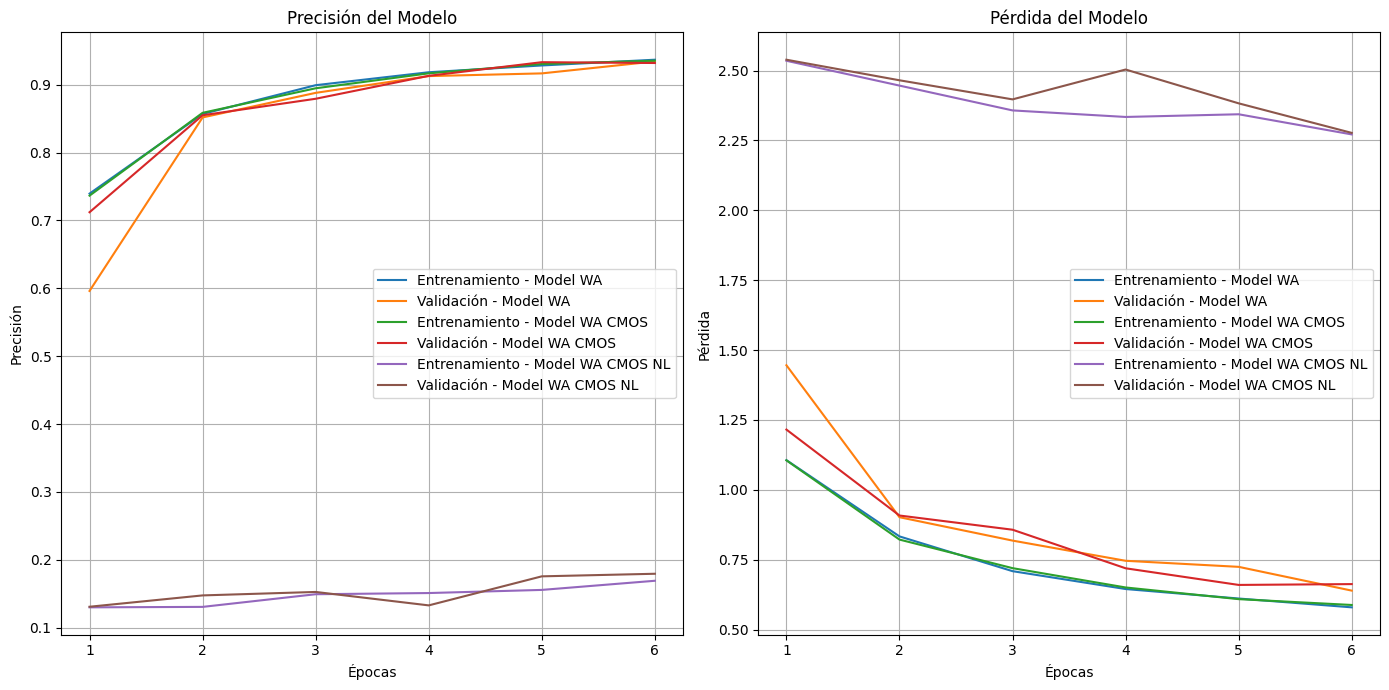

In [18]:
import matplotlib.pyplot as plt

# Supongamos que tienes los historiales después de entrenar los modelos
# history_wa = model_wa.fit(...)   # Entrenamiento del primer modelo
# history_wa_cmos = model_wa_cmos.fit(...)  # Entrenamiento del segundo modelo

# Extraer datos de los historiales
train_acc_wa = history_wa.history['accuracy']
val_acc_wa = history_wa.history['val_accuracy']
train_loss_wa = history_wa.history['loss']
val_loss_wa = history_wa.history['val_loss']

train_acc_wa_cmos = history_wa_cmos.history['accuracy']
val_acc_wa_cmos = history_wa_cmos.history['val_accuracy']
train_loss_wa_cmos = history_wa_cmos.history['loss']
val_loss_wa_cmos = history_wa_cmos.history['val_loss']

train_acc_wa_cmos_nl = history_wa_cmos_nl.history['accuracy']
val_acc_wa_cmos_nl = history_wa_cmos_nl.history['val_accuracy']
train_loss_wa_cmos_nl = history_wa_cmos_nl.history['loss']
val_loss_wa_cmos_nl = history_wa_cmos_nl.history['val_loss']

# Crear figuras para comparación de precisión y pérdida
epochs = range(1, len(train_acc_wa) + 1)

# Precisión
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_wa, label='Entrenamiento - Model WA')
plt.plot(epochs, val_acc_wa, label='Validación - Model WA')
plt.plot(epochs, train_acc_wa_cmos, label='Entrenamiento - Model WA CMOS')
plt.plot(epochs, val_acc_wa_cmos, label='Validación - Model WA CMOS')
plt.plot(epochs, train_acc_wa_cmos_nl, label='Entrenamiento - Model WA CMOS NL')
plt.plot(epochs, val_acc_wa_cmos_nl, label='Validación - Model WA CMOS NL')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_wa, label='Entrenamiento - Model WA')
plt.plot(epochs, val_loss_wa, label='Validación - Model WA')
plt.plot(epochs, train_loss_wa_cmos, label='Entrenamiento - Model WA CMOS')
plt.plot(epochs, val_loss_wa_cmos, label='Validación - Model WA CMOS')
plt.plot(epochs, train_loss_wa_cmos_nl, label='Entrenamiento - Model WA CMOS NL')
plt.plot(epochs, val_loss_wa_cmos_nl, label='Validación - Model WA CMOS NL')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Mostrar los gráficos
plt.tight_layout()
plt.show()


## 6. INFERENCIA

In [19]:
# Obtener las predicciones del modelo sobre el conjunto de prueba
y_pred_wa = model_wa.predict(test_images)
y_pred_wa_cmos = model_wa_cmos.predict(test_images)
y_pred_wa_cmos_nl = model_wa_cmos_nl.predict(test_images)

# Si el modelo tiene una activación softmax, debes tomar la clase con la probabilidad más alta (usualmente la de mayor valor)
y_pred_classes_wa = tf.argmax(y_pred_wa, axis=-1)  # Devuelve la clase con la mayor probabilidad para cada muestra
y_pred_classes_wa_cmos = tf.argmax(y_pred_wa_cmos, axis=-1)  # Devuelve la clase con la mayor probabilidad para cada muestra
y_pred_classes_wa_cmos_nl = tf.argmax(y_pred_wa_cmos_nl, axis=-1)  # Devuelve la clase con la mayor probabilidad para cada muestra


313/313 [==============================] - 15s 47ms/step


In [20]:
from sklearn.metrics import classification_report

# Función para generar y mostrar el reporte de clasificación de un modelo
def print_classification_report(true_labels, predictions, model_name):
    report = classification_report(true_labels, predictions)
    print(f"Classification Report - {model_name}")
    print(report)
    print("-" * 60)  # Línea de separación para mejorar la legibilidad

# Generar y mostrar los reportes de clasificación para cada modelo
print_classification_report(test_labels, y_pred_classes_wa, "Model WA")
print_classification_report(test_labels, y_pred_classes_wa_cmos, "Model WA_CMOS")
print_classification_report(test_labels, y_pred_classes_wa_cmos_nl, "Model WA_CMOS_NL")



Classification Report - Model WA
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       980
           1       0.95      0.82      0.88      1135
           2       0.83      0.84      0.84      1032
           3       0.73      0.92      0.81      1010
           4       0.85      0.81      0.83       982
           5       0.95      0.61      0.74       892
           6       0.87      0.90      0.88       958
           7       0.92      0.74      0.82      1028
           8       0.51      0.93      0.66       974
           9       0.91      0.59      0.72      1009

    accuracy                           0.81     10000
   macro avg       0.84      0.80      0.81     10000
weighted avg       0.84      0.81      0.81     10000

------------------------------------------------------------
Classification Report - Model WA_CMOS
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       980


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Comparativa

In [21]:
from sklearn.metrics import classification_report
import pandas as pd

# Generar los reportes de clasificación para cada modelo
report_wa = classification_report(test_labels, y_pred_classes_wa, output_dict=True)
report_wa_cmos = classification_report(test_labels, y_pred_classes_wa_cmos, output_dict=True)
report_wa_cmos_nl = classification_report(test_labels, y_pred_classes_wa_cmos_nl, output_dict=True)

# Convertir los reportes en DataFrames para facilitar la comparación
df_wa = pd.DataFrame(report_wa).transpose()
df_wa_cmos = pd.DataFrame(report_wa_cmos).transpose()
df_wa_cmos_nl = pd.DataFrame(report_wa_cmos_nl).transpose()

# Agregar las métricas globales (accuracy, precision, recall, f1-score) para cada modelo
df_comparison = pd.DataFrame({
    'Model WA': [report_wa['accuracy']],
    'Model WA_CMOS': [report_wa_cmos['accuracy']],
}, index=["Accuracy"])

# Mostrar también precision, recall y F1-score para cada modelo
df_comparison = pd.concat([
    df_comparison,
    pd.DataFrame({
        'Model WA': [df_wa.loc['macro avg', 'precision']],
        'Model WA_CMOS': [df_wa_cmos.loc['macro avg', 'precision']],
        'Model WA_CMOS_NL': [df_wa_cmos_nl.loc['macro avg', 'precision']],
    }, index=["Precision"]),
    pd.DataFrame({
        'Model WA': [df_wa.loc['macro avg', 'recall']],
        'Model WA_CMOS': [df_wa_cmos.loc['macro avg', 'recall']],
        'Model WA_CMOS_NL': [df_wa_cmos_nl.loc['macro avg', 'recall']],
    }, index=["Recall"]),
    pd.DataFrame({
        'Model WA': [df_wa.loc['macro avg', 'f1-score']],
        'Model WA_CMOS': [df_wa_cmos.loc['macro avg', 'f1-score']],
        'Model WA_CMOS_NL': [df_wa_cmos_nl.loc['macro avg', 'f1-score']],
    }, index=["F1-Score"])
], axis=0)

print(df_comparison)

           Model WA  Model WA_CMOS  Model WA_CMOS_NL
Accuracy   0.805400       0.795100               NaN
Precision  0.843351       0.831095          0.044564
Recall     0.804120       0.793956          0.125663
F1-Score   0.807727       0.798268          0.052675


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


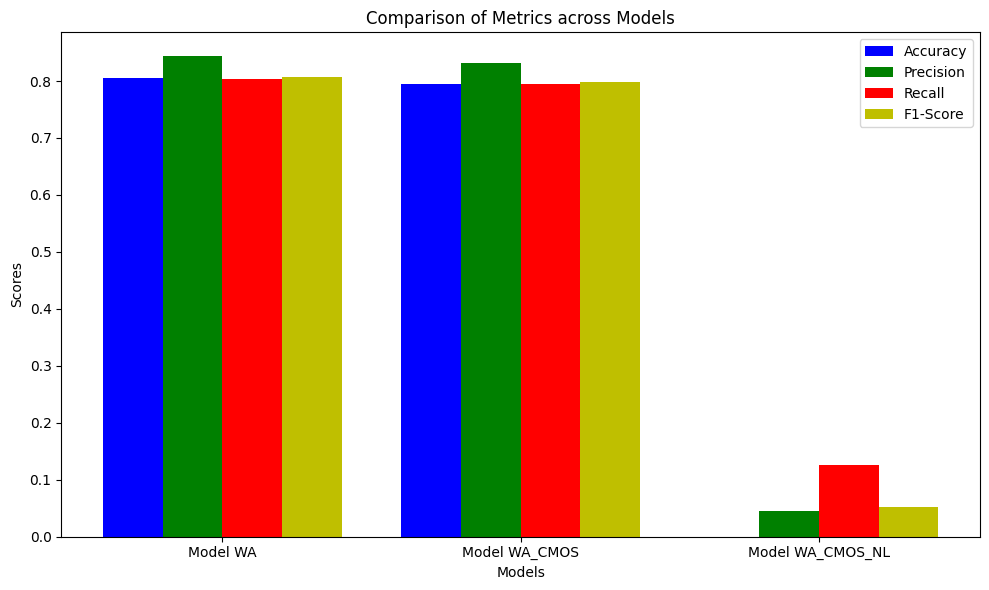

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un gráfico de barras comparando las métricas de precisión, recall, y f1-score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
model_names = ['Model WA', 'Model WA_CMOS', 'Model WA_CMOS_NL']

# Extraemos los valores de cada métrica para cada modelo
accuracy = [df_comparison.loc['Accuracy', 'Model WA'], df_comparison.loc['Accuracy', 'Model WA_CMOS'],df_comparison.loc['Accuracy', 'Model WA_CMOS_NL']]
precision = [df_comparison.loc['Precision', 'Model WA'], df_comparison.loc['Precision', 'Model WA_CMOS'],df_comparison.loc['Precision', 'Model WA_CMOS_NL']]
recall = [df_comparison.loc['Recall', 'Model WA'], df_comparison.loc['Recall', 'Model WA_CMOS'],df_comparison.loc['Recall', 'Model WA_CMOS_NL']]
f1_score = [df_comparison.loc['F1-Score', 'Model WA'], df_comparison.loc['F1-Score', 'Model WA_CMOS'],df_comparison.loc['F1-Score', 'Model WA_CMOS_NL']]

# Crear las subgráficas
x = np.arange(len(model_names))  # las posiciones de las barras en el eje x
width = 0.2  # El ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# Crear las barras para cada métrica
ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='b')
ax.bar(x - width*0.5, precision, width, label='Precision', color='g')
ax.bar(x + width*0.5, recall, width, label='Recall', color='r')
ax.bar(x + width*1.5, f1_score, width, label='F1-Score', color='y')

# Añadir etiquetas y título
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics across Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

plt.tight_layout()
plt.show()


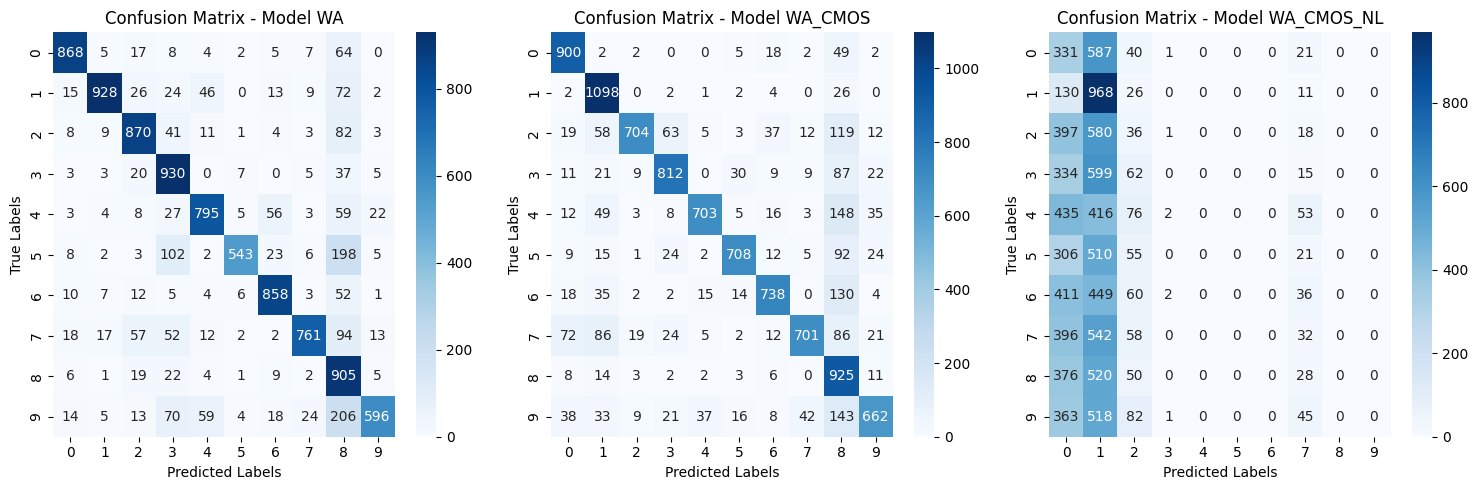

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular las matrices de confusión para cada modelo
conf_matrix_wa = confusion_matrix(test_labels, y_pred_classes_wa)
conf_matrix_w = confusion_matrix(test_labels, y_pred_classes_wa_cmos)
conf_matrix_w_nl = confusion_matrix(test_labels, y_pred_classes_wa_cmos_nl)


# Crear una figura con varias subgráficas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Visualizar la matriz de confusión de cada modelo
sns.heatmap(conf_matrix_wa, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels), ax=axes[0])
axes[0].set_title('Confusion Matrix - Model WA')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(conf_matrix_w, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels), ax=axes[1])
axes[1].set_title('Confusion Matrix - Model WA_CMOS')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

sns.heatmap(conf_matrix_w_nl, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels), ax=axes[2])
axes[2].set_title('Confusion Matrix - Model WA_CMOS_NL')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

El bajo rendimiento del modelo **WA_CMOS_NL** con respecto a los otros modelos probablemente se deba a la incorporación de las no linealidades de saturación, que pueden estar afectando severamente el aprendizaje y la capacidad de generalización del modelo. Aquí hay algunos factores que podrían contribuir al problema, junto con posibles soluciones:

### Problemas potenciales

1. **Magnitud de las saturaciones**:
   - Si los límites de saturación son demasiado restrictivos, muchas operaciones intermedias quedan truncadas o comprimidas, eliminando información valiosa.

2. **Impacto acumulativo**:
   - La saturación afecta cada capa, lo que podría amplificar el error a medida que las características se propagan a través del modelo.

3. **Ruido excesivo**:
   - Combinando saturaciones con las variaciones de CMOS y ruido ya presente, el modelo podría no estar recibiendo suficiente señal limpia para aprender patrones útiles.

4. **No optimización adecuada**:
   - La arquitectura y los hiperparámetros de entrenamiento (como la tasa de aprendizaje o el optimizador) pueden no estar adaptados a las nuevas características del modelo.

---

### Soluciones propuestas

1. **Ajustar los límites de saturación**:
   - Introducir límites más amplios y probar diferentes rangos para las saturaciones, por ejemplo, ajustarlos dinámicamente durante el entrenamiento o basarlos en la distribución de las activaciones.

2. **Capas no lineales más suaves**:
   - En lugar de una saturación brusca, usar una función que limite los valores suavemente, como `tanh` escalada al rango deseado o una versión suavizada del clamping.

3. **Normalización de activaciones antes de la saturación**:
   - Aplicar una normalización para reducir las activaciones extremas antes de imponer la saturación.

4. **Reducción del ruido inicial**:
   - Para que el modelo tenga una señal más clara durante las primeras etapas del entrenamiento, reducir los parámetros de ruido y variaciones del CMOS. Posteriormente, se puede incrementar gradualmente.

5. **Ajuste del entrenamiento**:
   - Usar una tasa de aprendizaje más baja y aumentar el número de épocas para permitir que el modelo se adapte a las restricciones.
   - Asegurarse de que el modelo esté adecuadamente inicializado para evitar pesos que causen saturaciones extremas desde el inicio.

6. **Ablación para identificar el problema**:
   - Entrenar el modelo primero sin saturación, luego añadirla progresivamente para observar en qué punto afecta al rendimiento.

---

### Próximos pasos

1. **Visualización**:
   - Analiza las activaciones intermedias para identificar dónde ocurre la saturación. Si la mayoría de las activaciones están en los límites de saturación, los límites son demasiado bajos o el modelo no se está entrenando adecuadamente.

2. **Implementar clamping dinámico**:
   - Ajustar los límites de saturación en función de estadísticas durante el entrenamiento, como la media y desviación estándar de las activaciones.

3. **Reducción del ruido**:
   - Prueba a reducir o eliminar el ruido de CMOS inicialmente y evalúa su efecto.

¿Quieres implementar alguna de estas soluciones? Por ejemplo, podría ayudarte a ajustar los límites de saturación o explorar la distribución de activaciones del modelo.